<a href="https://colab.research.google.com/github/Fjolnirr/Stalker/blob/main/pytorch_maskrcnn_training_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import random
from math import log10, sqrt
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import numpy as np
import torch.utils.data
import cv2
import torchvision.models.segmentation
import torch
import os
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab.patches import cv2_imshow

In [ ]:
batchSize = 5
imageSize = [600, 600]
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')  # train on the GPU or on the CPU, if a GPU is not available
trainDir = "/content/drive/MyDrive/ColabWorkspace/quadcopter_dataset/Train"

imgs = []
for pth in os.listdir(trainDir):
    if(pth.startswith(".")):
      continue
    imgs.append(trainDir + "/" + pth +"//")   
print(imgs)


['/content/drive/MyDrive/ColabWorkspace/quadcopter_dataset/Train/Train10//', '/content/drive/MyDrive/ColabWorkspace/quadcopter_dataset/Train/Train1//', '/content/drive/MyDrive/ColabWorkspace/quadcopter_dataset/Train/Train100//', '/content/drive/MyDrive/ColabWorkspace/quadcopter_dataset/Train/Train105//', '/content/drive/MyDrive/ColabWorkspace/quadcopter_dataset/Train/Train107//', '/content/drive/MyDrive/ColabWorkspace/quadcopter_dataset/Train/Train102//', '/content/drive/MyDrive/ColabWorkspace/quadcopter_dataset/Train/Train106//', '/content/drive/MyDrive/ColabWorkspace/quadcopter_dataset/Train/Train103//', '/content/drive/MyDrive/ColabWorkspace/quadcopter_dataset/Train/Train104//', '/content/drive/MyDrive/ColabWorkspace/quadcopter_dataset/Train/Train101//', '/content/drive/MyDrive/ColabWorkspace/quadcopter_dataset/Train/Train113//', '/content/drive/MyDrive/ColabWorkspace/quadcopter_dataset/Train/Train11//', '/content/drive/MyDrive/ColabWorkspace/quadcopter_dataset/Train/Train110//', '/

In [ ]:
def loadData():
    batch_Imgs = []
    batch_Data = []  # load images and masks
    for i in range(batchSize):
        idx = random.randint(0, len(imgs) - 1)
        img = cv2.imread(os.path.join(imgs[idx], "Image.jpg"))
        img = cv2.resize(img, (600,600), cv2.INTER_LINEAR)
        maskDir = os.path.join(imgs[idx], "Vessels")
        masks = []
        for mskName in os.listdir(maskDir):
            vesMask = (cv2.imread(maskDir + '/' + mskName, 0) > 0).astype(np.uint8)  # Read vesse instance mask
            
            vesMask = cv2.resize(vesMask, (600,600), cv2.INTER_NEAREST)
            masks.append(vesMask)  # get bounding box coordinates for each mask
        num_objs = len(masks)
        if num_objs == 0: return loadData()  # if image have no objects just load another image
        boxes = torch.zeros([num_objs, 4], dtype=torch.float32)

        for i in range(num_objs):
            x, y, w, h = cv2.boundingRect(masks[i])
            boxes[i] = torch.tensor([x, y, x + w, y + h])
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        img = torch.as_tensor(img, dtype=torch.float32)
        data = {}
        data["boxes"] = boxes
        data["labels"] = torch.ones((num_objs,), dtype=torch.int64)  # there is only one class
        data["masks"] = masks
        batch_Imgs.append(img)
        batch_Data.append(data)  # load images and masks
    batch_Imgs = torch.stack([torch.as_tensor(d) for d in batch_Imgs], 0)
    batch_Imgs = batch_Imgs.swapaxes(1, 3).swapaxes(2, 3)
    return batch_Imgs, batch_Data


In [ ]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)  # load an instance segmentation model pre-trained pre-trained on COCO
in_features = model.roi_heads.box_predictor.cls_score.in_features  # get number of input features for the classifier
model.roi_heads.box_predictor = FastRCNNPredictor(in_features,
                                                  num_classes=2)  # replace the pre-trained head with a new one
model.to(device)  # move model to the right device

optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-5)
model.train()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [ ]:
#@title Prediction_mask kodu
def prediction_mask(checkpoint_no, im="/content/drive/MyDrive/ColabWorkspace/quadcopter_dataset/Train/Train1/Image.jpg"):
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')  
  model=torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True) 
  in_features = model.roi_heads.box_predictor.cls_score.in_features 
  model.roi_heads.box_predictor=FastRCNNPredictor(in_features,num_classes=2)
  model.load_state_dict(torch.load("/content/drive/MyDrive/ColabWorkspace/quadcopter_dataset/Weights/epoch"+ str(checkpoint_no) +".torch"))
  model.to(device)# move model to the right devic
  model.eval()

  images = cv2.imread(im)
  images = cv2.resize(images, (600,600), cv2.INTER_LINEAR)
  images = torch.as_tensor(images, dtype=torch.float32).unsqueeze(0)
  images=images.swapaxes(1, 3).swapaxes(2, 3)
  images = list(image.to(device) for image in images)

  with torch.no_grad():
    pred = model(images)
    pred_mask = pred[0]['masks'][0].cpu().data.numpy()
    bbox = pred[0]['boxes'][0].cpu().data.numpy()
    bbox = [int(x) for x in bbox]

  return pred_mask[0], bbox

In [ ]:
#@title PSNR kodu
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

In [ ]:
#@title evaluate_model kodu
def evaluate_model(truth, pred):
  MSE = np.square(np.subtract(truth,pred)).mean()
  return MSE

In [ ]:
mse_list = []
psnr_list = []
epoch = 1000
for i in range(epoch+1):
    images, targets = loadData()
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    ground_truth_mask = targets[0]['masks'][0].cpu().data.numpy()

    optimizer.zero_grad()
    loss_dict = model(images, targets)
    #print(loss_dict)

    losses = sum(loss for loss in loss_dict.values())
    losses.backward()
    optimizer.step()
    print("epoch : ", i, 'loss :', losses.item())

    if i % 100 == 0:
        torch.save(model.state_dict(), "/content/drive/MyDrive/ColabWorkspace/quadcopter_dataset/Weights/epoch" + str(i) + ".torch")
        #pred_mask, bbox = prediction_mask(i)

        #mse = evaluate_model(ground_truth_mask, pred_mask)
        #mse_list.append(mse)

        #psnr = PSNR(ground_truth_mask, pred_mask)
        #psnr_list.append(psnr)

"""
#plt.figure()
#plt.plot(mse_list)

plt.figure()
plt.plot(psnr_list)

cv2_imshow(np.hstack([ground_truth_mask*200,pred_mask*200]))
img = cv2.imread("/content/drive/MyDrive/ColabWorkspace/quadcopter_dataset/Train/Train1/Image.jpg")
cv2.rectangle(img,bbox,(0,255,0),3)
cv2_imshow(img)
"""

epoch :  0 loss : 1.9907547235488892
epoch :  1 loss : 1.7690821886062622
epoch :  2 loss : 1.3360686302185059
epoch :  3 loss : 4.920501232147217
epoch :  4 loss : 1.8832728862762451
epoch :  5 loss : 18.022720336914062
epoch :  6 loss : 1.4663622379302979
epoch :  7 loss : 3.033313274383545
epoch :  8 loss : 2.060159683227539
epoch :  9 loss : 3.106370449066162
epoch :  10 loss : 2.954113483428955
epoch :  11 loss : 3.667370080947876
epoch :  12 loss : 4.727351665496826
epoch :  13 loss : 1.6022711992263794
epoch :  14 loss : 1.848008394241333
epoch :  15 loss : 2.935183525085449
epoch :  16 loss : 1.7414884567260742
epoch :  17 loss : 7.772017955780029
epoch :  18 loss : 2.6796157360076904
epoch :  19 loss : 3.238593816757202
epoch :  20 loss : 6.087221145629883
epoch :  21 loss : 1.1186264753341675
epoch :  22 loss : 3.3592417240142822
epoch :  23 loss : 4.795136451721191
epoch :  24 loss : 5.636802673339844
epoch :  25 loss : 4.440966606140137
epoch :  26 loss : 2.7013440132141113

'\n#plt.figure()\n#plt.plot(mse_list)\n\nplt.figure()\nplt.plot(psnr_list)\n\ncv2_imshow(np.hstack([ground_truth_mask*200,pred_mask*200]))\nimg = cv2.imread("/content/drive/MyDrive/ColabWorkspace/quadcopter_dataset/Train/Train1/Image.jpg")\ncv2.rectangle(img,bbox,(0,255,0),3)\ncv2_imshow(img)\n'

In [ ]:
cv2_imshow(np.hstack([ground_truth_mask*200,pred_mask*200]))
img = cv2.imread("/content/drive/MyDrive/ColabWorkspace/quadcopter_dataset/Train/Train1/Image.jpg")
cv2.rectangle(img,bbox,(0,255,0),3)
cv2_imshow(img)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


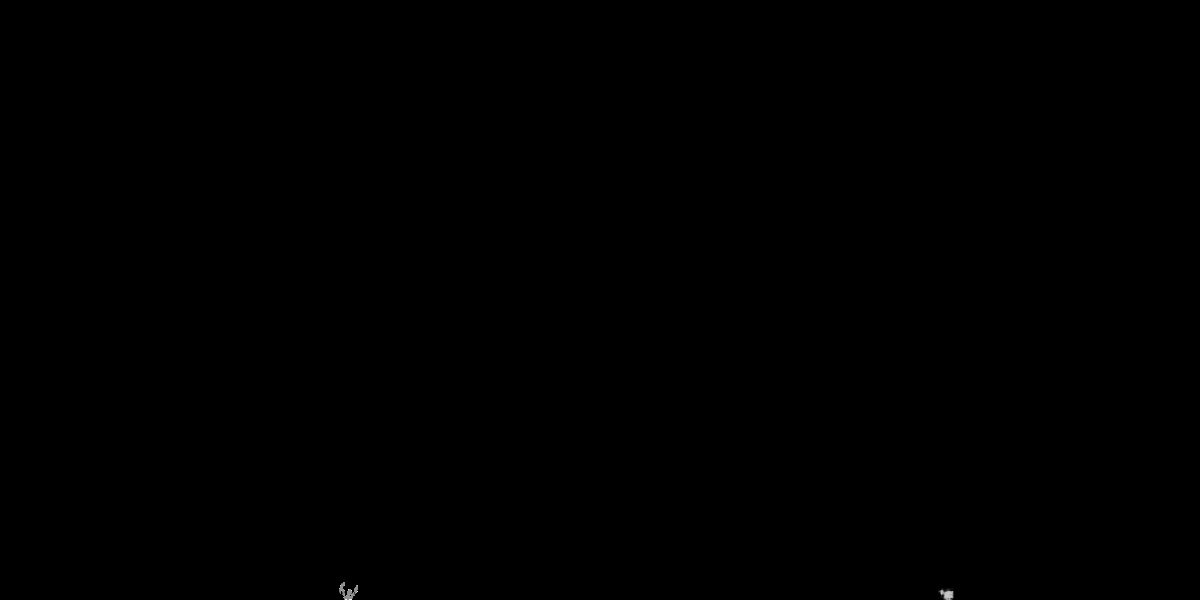

[338, 588, 352, 600]


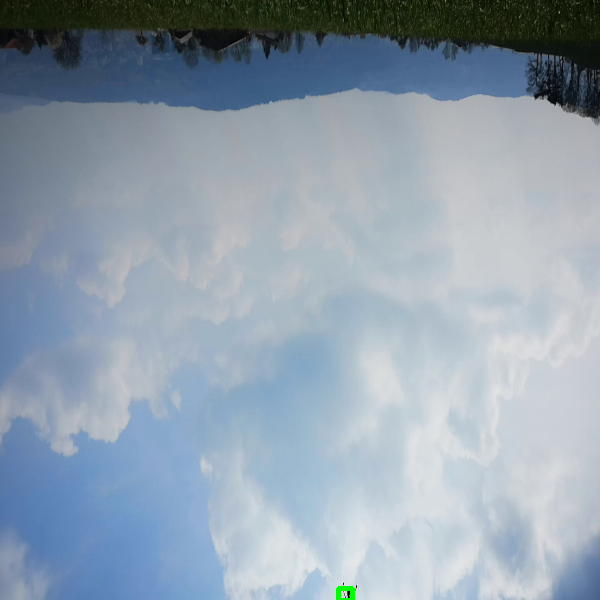

In [ ]:
pred_mask, bbox = prediction_mask(1000, "/content/drive/MyDrive/ColabWorkspace/quadcopter_dataset/Train/Train100/Image.jpg")
truth = cv2.imread("/content/drive/MyDrive/ColabWorkspace/quadcopter_dataset/Train/Train100/Vessels/cam1frame88_mask.png", 0)
truth = cv2.resize(truth, (600,600))
cv2_imshow(np.hstack([truth*200,pred_mask*200]))

print(bbox)

img = cv2.imread("/content/drive/MyDrive/ColabWorkspace/quadcopter_dataset/Train/Train100/Image.jpg")
img = cv2.resize(img, (600,600))
cv2.rectangle(img,(bbox[0],bbox[1]), (bbox[2], bbox[3]),(0,255,0),3)
cv2_imshow(img)

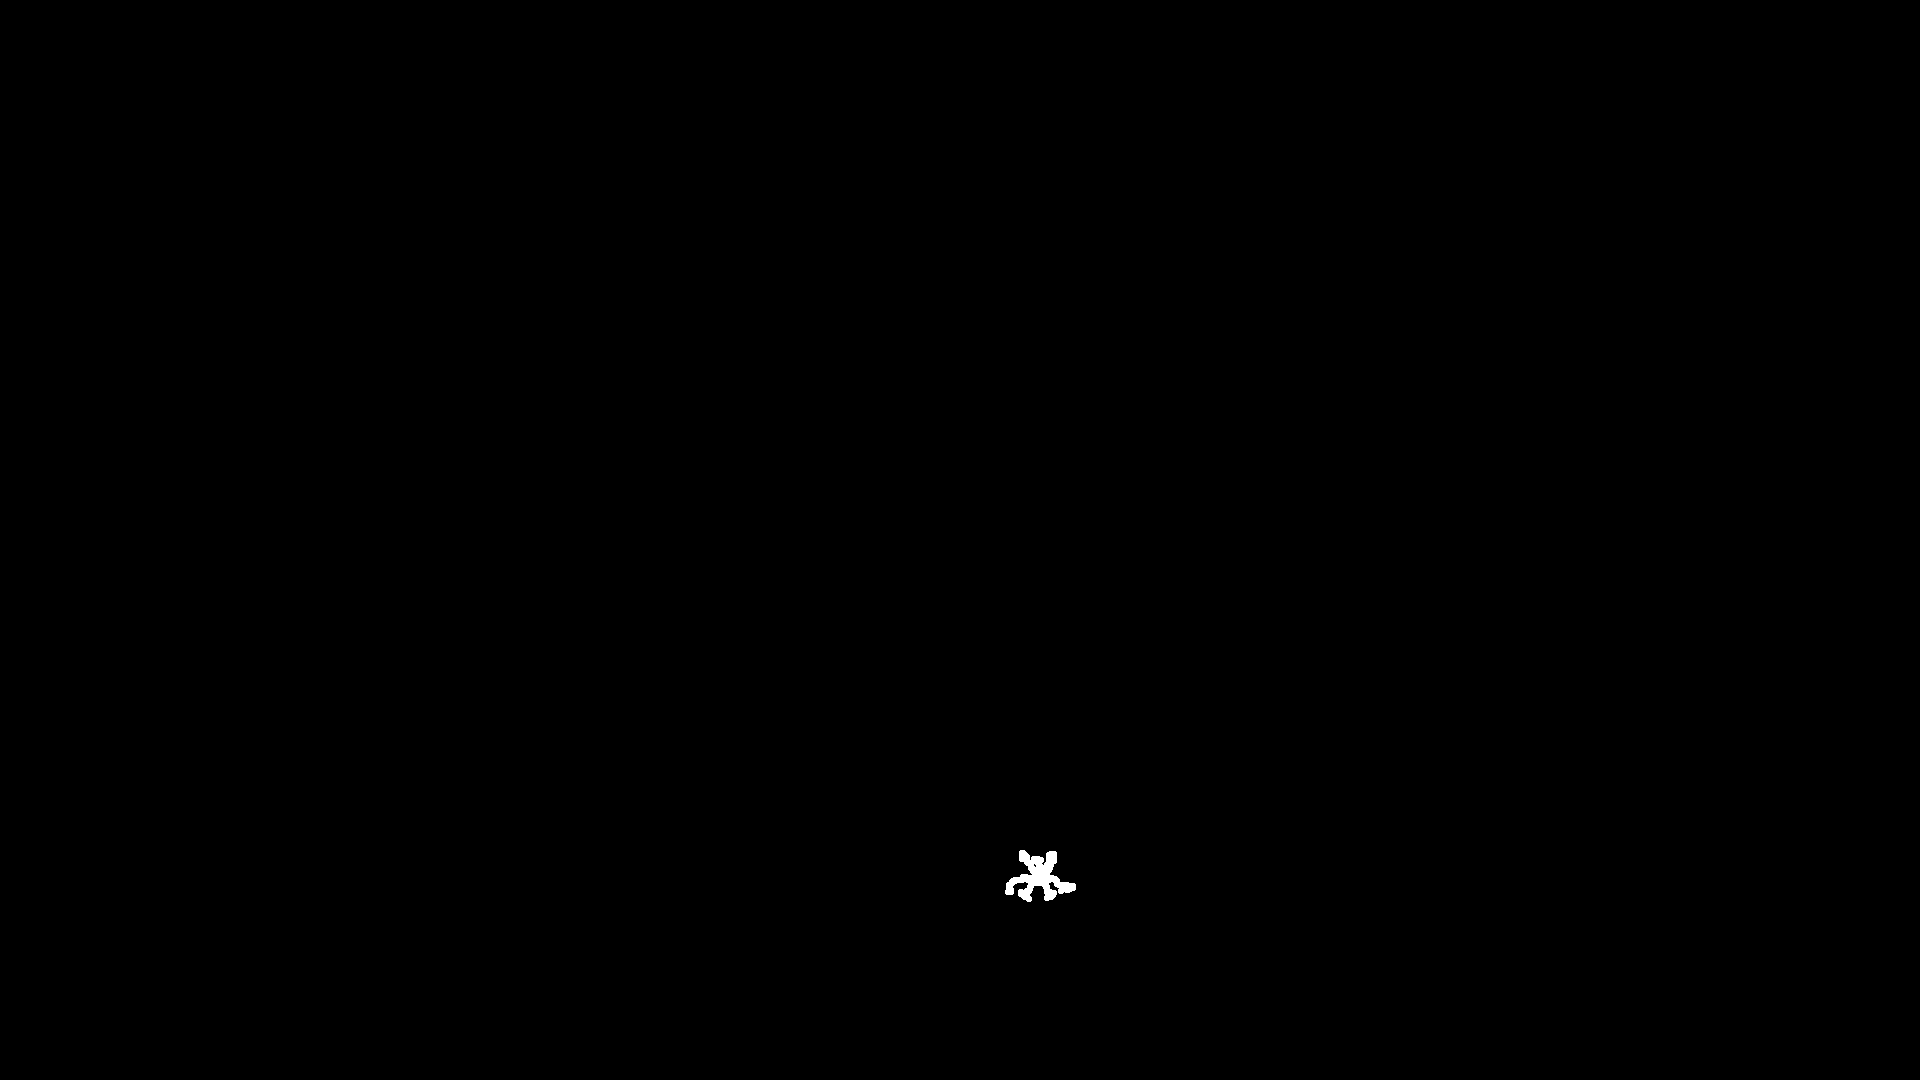

In [ ]:
gry = cv2.imread("/content/drive/MyDrive/ColabWorkspace/quadcopter_dataset/Train/Train1/Vessels/cam1frame0_mask.png")
ret,thresh1 = cv2.threshold(gry,1,1,cv2.THRESH_BINARY)
cv2_imshow(thresh1*255)
#####cv2.imwrite("/content/drive/MyDrive/ColabWorkspace/UAVdataset/Train/Train1/Masks/mask3.png", thresh1)


TEST SECTION

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')  
model=torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True) 
in_features = model.roi_heads.box_predictor.cls_score.in_features 
model.roi_heads.box_predictor=FastRCNNPredictor(in_features,num_classes=2)
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/LabPicsChemistry/weights8.torch"))
model.to(device)# move model to the right devic
model.eval()

In [ ]:
images = cv2.imread("/content/drive/MyDrive/Colab Notebooks/LabPicsChemistry/Train/Train1/Image.jpg")
images = cv2.resize(images, (600,600), cv2.INTER_LINEAR)
images = torch.as_tensor(images, dtype=torch.float32).unsqueeze(0)
images=images.swapaxes(1, 3).swapaxes(2, 3)
images = list(image.to(device) for image in images)

[{'boxes': tensor([[140.2388, 353.3153, 348.4410, 384.2507]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1636], device='cuda:0'), 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')}]
1.0


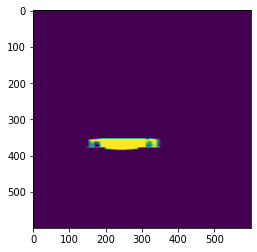

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
with torch.no_grad():
    pred = model(images)
    print(pred)
    resim = pred[0]['masks'][0].cpu().data.numpy()
    print(resim[0][370,250])
    #plt.figure()
    plt.imshow(resim[0]*255)

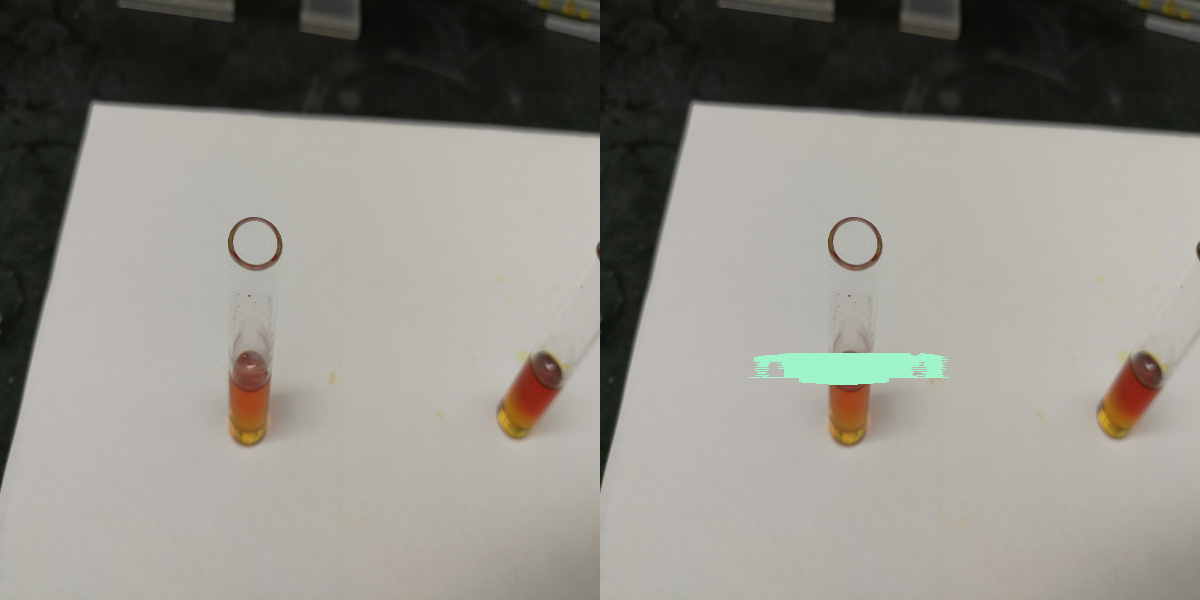

-1

In [ ]:
from google.colab.patches import cv2_imshow
im= images[0].swapaxes(0, 2).swapaxes(0, 1).detach().cpu().numpy().astype(np.uint8)
im2 = im.copy()
for i in range(len(pred[0]['masks'])):
    msk=pred[0]['masks'][i,0].detach().cpu().numpy()
    scr=pred[0]['scores'][i].detach().cpu().numpy()
    if scr>0.1 :
        im2[:,:,0][msk>0.5] = random.randint(0,255)
        im2[:, :, 1][msk > 0.5] = random.randint(0,255)
        im2[:, :, 2][msk > 0.5] = random.randint(0, 255)
#cv2_imshow(str(scr), np.hstack([im,im2]))
cv2_imshow(np.hstack([im,im2]))


cv2.waitKey()

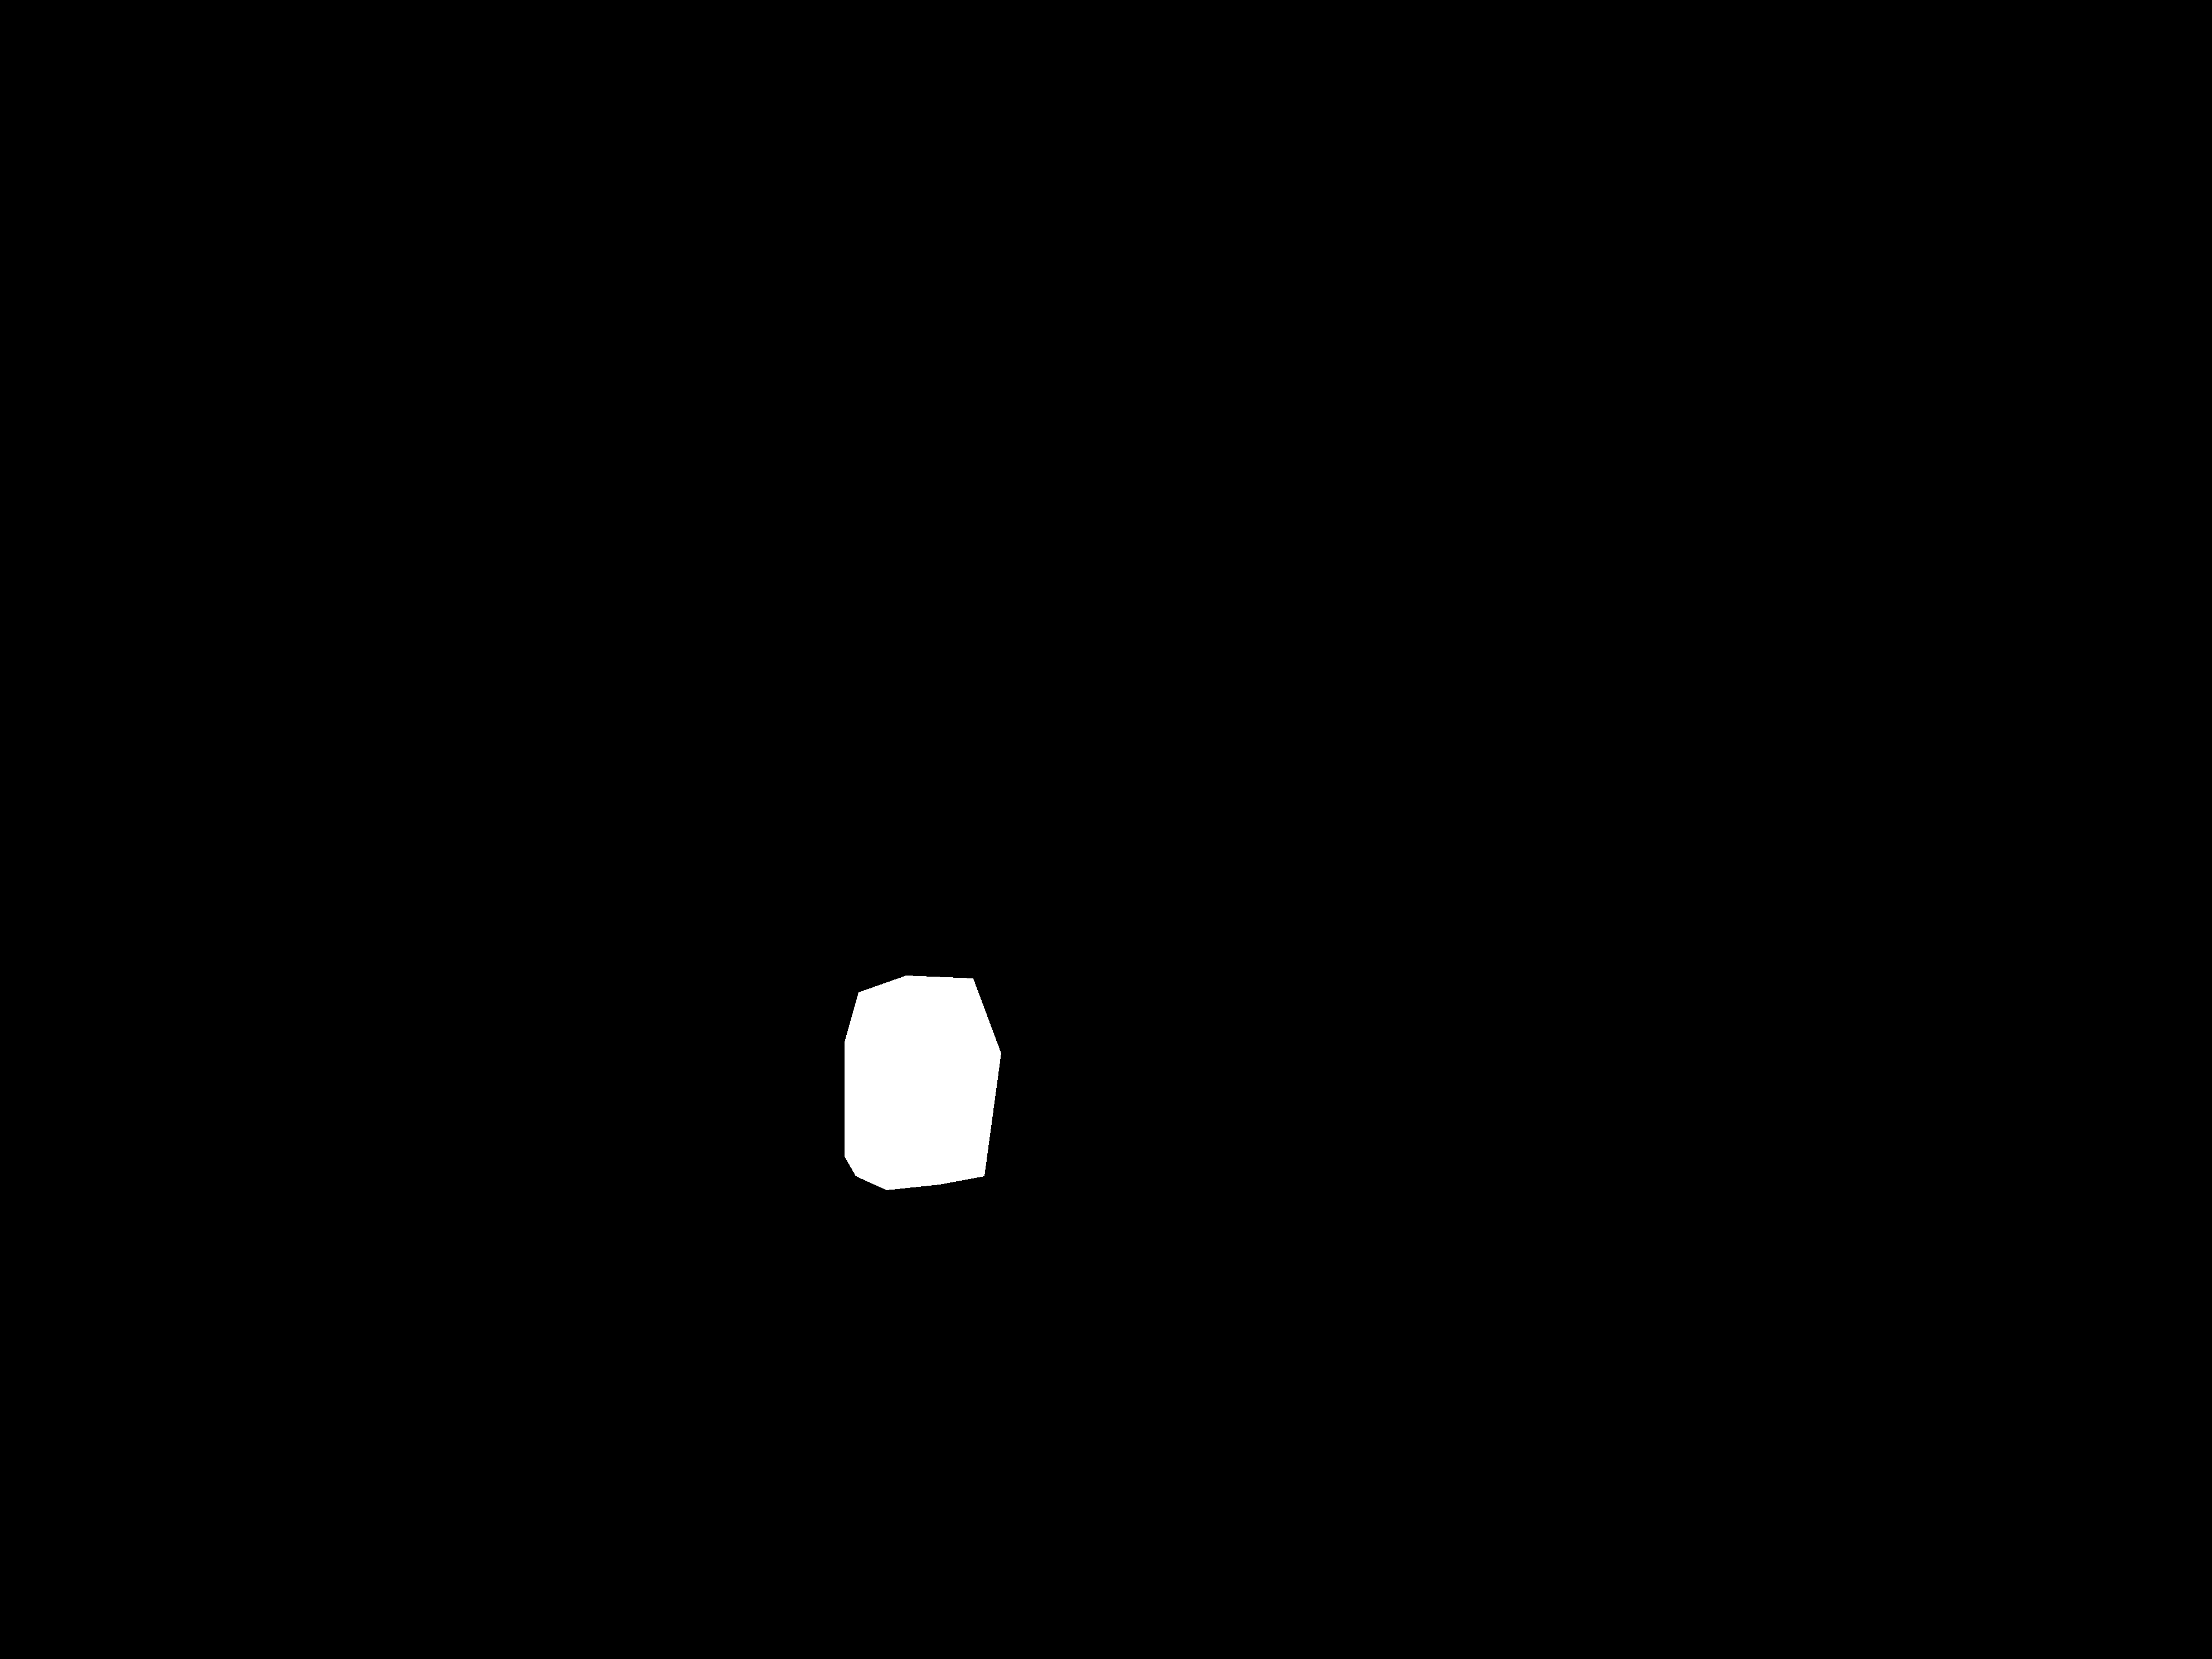

In [ ]:
ves = cv2.imread("/content/drive/MyDrive/Colab Notebooks/LabPicsChemistry/Train/Train1/SemanticMaps/PerVessel/1/Liquid.png")
cv2_imshow(ves*255)